# PREDICCIÓN DE VENTAS FUTURAS

## PREPARACIÓN DE LOS DATOS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/venta.csv', sep=",") #Ordena el dataFrame respecto al índice que es  la columna FECHA

In [ ]:
data['FECHA'] = pd.to_datetime(data['FECHA'], format = '%d/%m/%Y')
data.set_index('FECHA', inplace=True)
data.sort_index(inplace=True, ascending=True)

In [ ]:
data

,ValorVenta
FECHA,
2023-01-02,1.561314e+01
2023-01-03,7.148584e+05
2023-01-04,8.370905e+05
2023-01-05,8.078090e+05
2023-01-06,7.978924e+05
...,...
2023-10-09,6.222160e+06
2023-10-10,6.621843e+06
2023-10-11,6.469491e+06


## ANÁLISIS EXPLORATORIO (EDA)

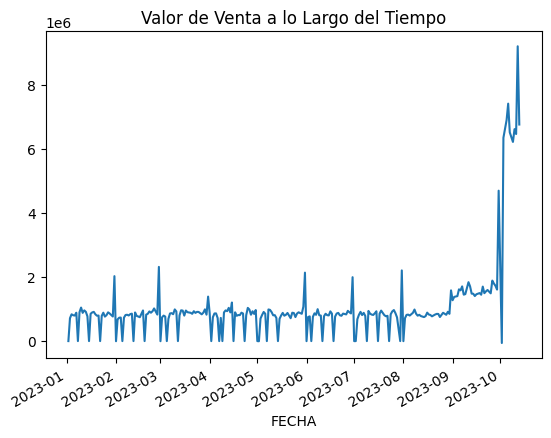

In [ ]:
# Gráfico de Serie Temporal
data['ValorVenta'].plot()
plt.title('Valor de Venta a lo Largo del Tiempo')
plt.show()

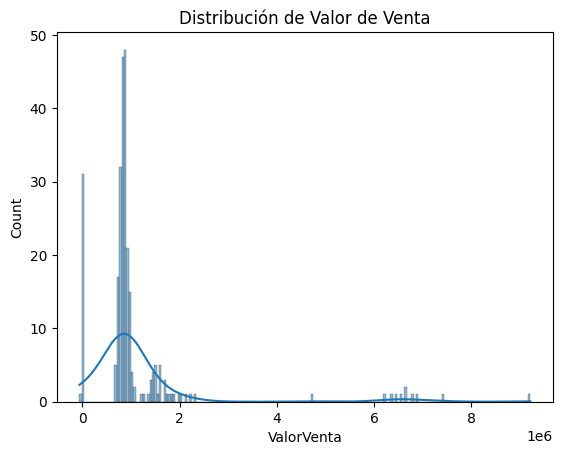

In [ ]:
# Histograma
sns.histplot(data['ValorVenta'], kde=True)
plt.title('Distribución de Valor de Venta')
plt.show()

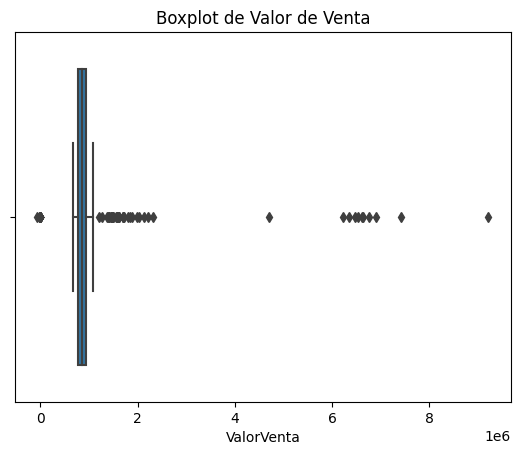

In [ ]:
# Diagrama de Cajas
sns.boxplot(x=data['ValorVenta'])
plt.title('Boxplot de Valor de Venta')
plt.show()

## PREPROCESAMIENTO DE LOS DATOS

Escalar los datos y preparar los conjuntos de entrenamiento y prueba:

In [ ]:
# Escalar los valores
scaler = MinMaxScaler() #Transforma cada columna entre 0 y 1
data_scaled = scaler.fit_transform(data) #

In [ ]:
# Creamos sequencias de datos para el modelo LSTM
def create_sequences(data, sequence_lenght): #Longitud de la secuencia deseada para cada muestra
  X, y = [], []
  for i in range(len(data) - sequence_lenght):
    X.append(data[i:i+sequence_lenght])
    y.append(data[i+sequence_lenght])
  return np.array(X), np.array(y)

SEQUENCE_LENGHT = 5
X, y = create_sequences(data_scaled, SEQUENCE_LENGHT)

In [ ]:
# Dividir datos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

## CONSTRUCCIÓN DEL MODELO LSTM

Construir y compilar el modelo LSTM:



In [ ]:
# Definamos el modelo LSTM

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (SEQUENCE_LENGHT, 1)))
model.add(LSTM(50))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## ENTRENAMIENTO DEL MODELO

Entrenar el modelo utilizando los datos preparados:

In [ ]:
# Entrenar el modelo

history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.1,
    verbose = 1
)

Epoch 1/50
6/6 [==============================] - 4s 263ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 11/50
6/6 [===========

## EVALUACIÓN DEL MODELO

Visualizar el proceso de entrenamiento y realizar evaluaciones:

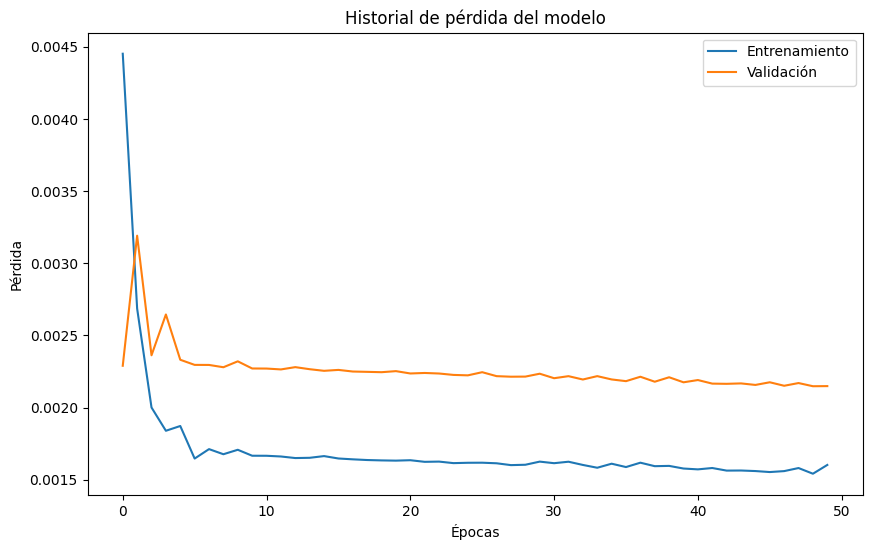

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Historial de pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Hacer predicciones

y_pred = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# Invertir la escala

y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
# Calcular RMSE

rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled)**2))
print('RMSE:', rmse)

RMSE: 3577156.701171889


## REALIZAR PREDICCIONES FUTURAS

Para hacer predicciones futuras, preparamos los últimos datos y los pasaremos al modelo:

In [ ]:
# Preparar los últimos datos

last_sequence = data_scaled[-SEQUENCE_LENGHT:]
last_sequence = np.expand_dims(last_sequence, axis=0)

In [ ]:
# Hacer predicciones futuras

predicted_sales = model.predict(last_sequence)

1/1 [==============================] - 0s 24ms/step


In [ ]:
# Invertir la escala de la predicción

predicted_sales_rescaled = scaler.inverse_transform(predicted_sales)
print(f'La Venta pronosticada es: {predicted_sales_rescaled[0][0]}')

La Venta pronosticada es: -1618875.0


## AJUSTE DE HIPERPARÁMETROS

Para el ajuste de hiperparametros, realizaremos un proceso manual ajustando hiperparámetros como el número de neuronas, capas, tasa de aprendizaje, etc.

In [ ]:
!pip install keras-tuner

In [ ]:
def build_model(n_units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(SEQUENCE_LENGHT, 1)))
    model.add(LSTM(units=n_units))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
import tensorflow as tf

# Definimos un rango de posibles valores para cada hiperparámetro
unit_options = [50, 100, 150]
learning_rate_options = [0.01, 0.001, 0.0001]

results = {}

for units in unit_options:
    for lr in learning_rate_options:
        # Construye el modelo con los hiperparámetros actuales
        model = build_model(n_units=units, learning_rate=lr)

        # Entrena el modelo y guarda el historial
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )

        val_loss = model.evaluate(X_test, y_test, verbose=0)

        results[(units, lr)] = val_loss
        print(f"Units: {units}, Learning Rate: {lr}, Validation Loss: {val_loss}")

Units: 50, Learning Rate: 0.01, Validation Loss: 0.10821660608053207
Units: 50, Learning Rate: 0.001, Validation Loss: 0.1354135423898697
Units: 50, Learning Rate: 0.0001, Validation Loss: 0.07591971755027771
Units: 100, Learning Rate: 0.01, Validation Loss: 0.1433044970035553
Units: 100, Learning Rate: 0.001, Validation Loss: 0.16258691251277924
Units: 100, Learning Rate: 0.0001, Validation Loss: 0.07528728246688843
Units: 150, Learning Rate: 0.01, Validation Loss: 0.10480555891990662
Units: 150, Learning Rate: 0.001, Validation Loss: 0.14716576039791107
Units: 150, Learning Rate: 0.0001, Validation Loss: 0.08138249069452286


## EVALUACIÓN DEL MODELO AJUSTADO

In [ ]:
# Encuentra los mejores hiperparámetros
best_params = min(results, key=results.get)
best_units, best_lr = best_params

# Construye y entrena el modelo final usando los mejores hiperparámetros
best_model = build_model(n_units=best_units, learning_rate=best_lr)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evalúa el modelo en el conjunto de prueba
final_loss = best_model.evaluate(X_test, y_test)
print(f'El mejor modelo tiene una pérdida en el conjunto de prueba de: {final_loss}')

Epoch 1/50
7/7 [==============================] - 3s 7ms/step - loss: 0.0090
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 8/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 10/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 11/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0018
Epoch 12/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 13/50
7/7 [==============================] - 0s 10ms/step - 

In [ ]:
# Toma la última secuencia de datos
last_sequence = data_scaled[-SEQUENCE_LENGHT:]

# Expande las dimensiones para que coincida con la entrada esperada por el modelo
last_sequence = np.expand_dims(last_sequence, axis=0)


## REALIZAR PREDICCIONES FUTURAS CON EL MODELO AJUSTADO


In [ ]:
# Hacer la predicción utilizando el mejor modelo
predicted_sales_scaled = best_model.predict(last_sequence)

# Deshacer el escalado de la predicción para obtener el valor en la escala original
predicted_sales = scaler.inverse_transform(predicted_sales_scaled)

1/1 [==============================] - 0s 15ms/step


In [ ]:
# Muestra la predicción de ventas futuras
next_time_step = data.index[-1] + pd.Timedelta(days=1)  # Ajustar según la frecuencia de tus datos
print(f'La venta pronosticada para {next_time_step.date()} es {predicted_sales[0][0]}')


La venta pronosticada para 2023-10-14 es 1361846.25


In [ ]:
future_steps = 5
future_sales = []
current_sequence = last_sequence

for _ in range(future_steps):
    # Usando el modelo para hacer la predicción
    current_prediction_scaled = best_model.predict(current_sequence)
    # Deshaciendo el escalado
    current_prediction = scaler.inverse_transform(current_prediction_scaled)
    # Guardar la predicción
    future_sales.append(current_prediction[0][0])
    # Actualizar la secuencia de entrada para incluir la nueva predicción
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[:, -1, :] = current_prediction_scaled

# Ventas futuras pronosticadas
for i, sale in enumerate(future_sales, start=1):
    next_step = data.index[-1] + pd.Timedelta(days=i)  # Ajusta según la frecuencia de tus datos
    print(f'La venta pronosticada para {next_step.date()} es {sale}')

1/1 [==============================] - 0s 15ms/step
La venta pronosticada para 2023-10-14 es 1361846.25
La venta pronosticada para 2023-10-15 es 1341827.75
La venta pronosticada para 2023-10-16 es 1268675.625
La venta pronosticada para 2023-10-17 es 1165985.0
La venta pronosticada para 2023-10-18 es 965343.5625
